In [2]:
#A continuación importamos las librerias que utilizaremos. 
!pip install np
!pip install matplotlib
!pip install tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

from matplotlib import cm
import math
from tqdm import tqdm

# Taller 2: Métodos Computacionales
### Estudiantes: Andrés Hernández (201329363)    Francisco Díaz (201912252)

## Generador de números aleatorios
**1.** Un test simple para probar la calidad de un generador de eventos es evaluar las correlaciones con los $k$-vecinos más cercanos donde $k \sim 20 $
$$
C(k) = \frac{1}{N} \sum_{i=1}^{N} x_{i}x_{i+k} \; \; \; (k = 0,1,2,...)
$$


a) Implemente un código (en C++ y en Python) que estime los coeficientes de correlación para los primeros $k=20$ vecinos. Use $N = 10^3$ eventos para ambos generadores ($simple$ y $drand48$ ).

In [25]:
class MyRandom():
    
    def __init__(self, seed = 15 , method = 'simple'):
        
        self.r = seed
        self.method = method
        
        if method == 'simple':
            self.a = 57 
            self.c = 1
            self.M = 265
        elif method == "drand48":
            self.a = int('5DEECE66D',16) 
            self.c = int('B', 16)
            self.M = 2 **48
        else:
            print('Generador no reconocido')
    
    def Random(self):
        
        r= (self.a*self.r + self.c)%self.M
        self.r = r
        
        return r/float(self.M)
    
    def k_vecinos( self, i_, X_sample_, k_) :
   
        distancias = np.zeros( len(X_sample_ ))
        
        for j in range( len(X_sample_)) :
              
            d = np.abs( X_sample_[j] - X_sample_[i_])
              
            distancias[j] = d
          
        inds = distancias.argsort()
          
        X_sorted = X_sample_[inds]
        
        return X_sorted[1:k_+1]
   
    def Correlation(self, sample_, k_, seed_ = 32 , method_ = 'simple'):
        
        rand = MyRandom(seed = seed_ , method = method_)
        Npoints = len(sample_)

        k_vecinos = []
        
        for i in range (Npoints):
            k_vecinos_i = rand.k_vecinos(  i_ =i , X_sample_ = sample_ , k_ = k_ )
            k_vecinos.append(k_vecinos_i)
            
        Ck = []
        
        for k in range(0,k_):
            sum = 0
            
            for j in range (Npoints-k-1):        
                #sum += sample_[j]*k_vecinos[j][k-1]
                sum += sample_[j]*sample_[j+k+1]
            sum *= 1/Npoints
        
            Ck.append(sum)               
        
        return Ck


def FillPoints(Npoints_ , seed_ ,method_ ):
    
    rand = MyRandom(seed = seed_ , method = method_)
    
    points = np.zeros(Npoints_)
    
    for i in tqdm(range(Npoints_)):
        points[i] = rand.Random()
        
    return points

Npoints, k = int(1e3), 30

method1 = 'simple'
method2 = 'drand48'
rand1 =  MyRandom( seed = 6625 , method=method1)
sample1 = FillPoints(Npoints,  6625 , method1)
rand2 =  MyRandom( seed = 6625 , method=method2)
sample2 = FillPoints(Npoints,  6625 , method2)

Ck1 = rand1.Correlation(sample1,k ,6625, method1)
Ck2 = rand2.Correlation(sample2,k , 6625, method2)


100%|██████████| 1000/1000 [00:00<00:00, 333649.19it/s]


b) Haga una gráfica entre el valor del coeficiente $C(k)$ en función del momento de la distribución $k$. ¿Qué diferencia encuentra entre ambos generadores?


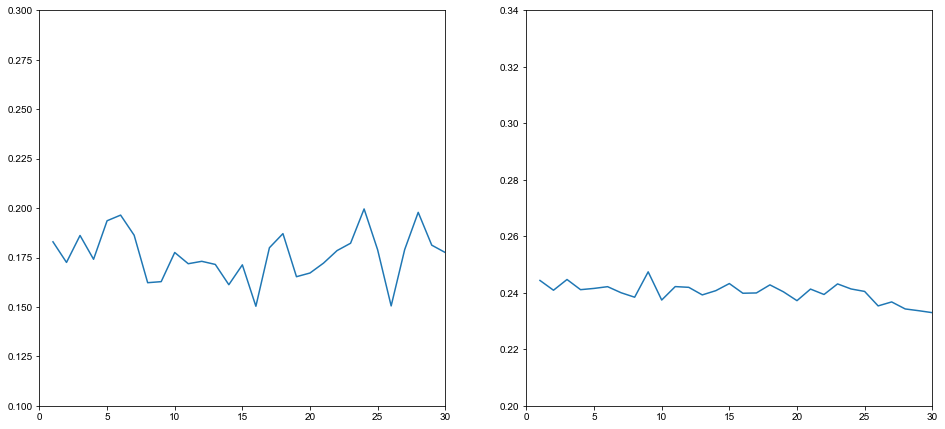

In [26]:
x = np.linspace(1, k , k)

fig = plt.figure(figsize=(16,16))
ax1= fig.add_subplot(2,2,1)
ax2= fig.add_subplot(2,2,2)

ax1.plot(x,Ck1)
ax2.plot(x,Ck2)
ax1.set_xlim(0,k)
ax1.set_ylim(0.1,0.3)
ax2.set_xlim(0,k)
ax2.set_ylim(0.2,0.34)

plt.style.use('seaborn-whitegrid')
plt.show()

## 2. Generación 3D de eventos
**1.** Escrbia un código que genere una secuencia uniforme de eventos contenidos en una esfera de radio R = 2 como se muestra en la fígura.

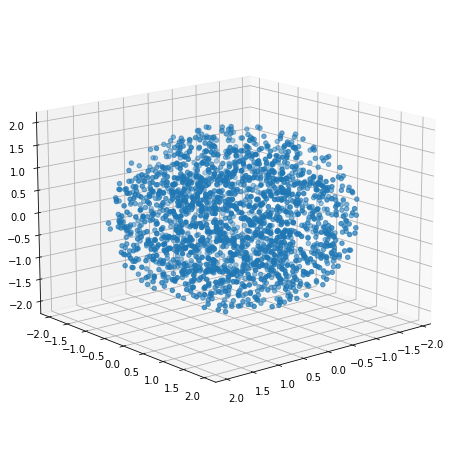

In [4]:
def CreateSphere(Npoints, R):
    
    X = []
    Y = []
    Z = []

    r = 0.
    theta = 0.
    phi = 0.
    
    for i in range(Npoints):
        
        phi = np.random.uniform(0.,2*np.pi)
        costheta = np.random.uniform(-1.,1.)
        theta = np.arccos(costheta)
        u = np.random.rand()
        
        r = R*u**(1./3.)
        
        X = np.append(X, r*np.cos(phi)*np.sin(theta))
        Y = np.append(Y, r*np.sin(phi)*np.sin(theta))
        Z = np.append(Z, r*np.cos(theta))
        
    return X,Y,Z

N, R =  int(2e3), 2
data_sphere = np.array(CreateSphere(N,R))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(15,50)
ax.scatter(data_sphere[0],data_sphere[1],data_sphere[2])
plt.show()

## 3. Integración MonteCarlo
**1.** Usando la generación de puntos sobre una esfera estime la siguiente integral (en C++ y en python), para $\{x^{2}+y^{2}+z^{2} \leq 1 \} $:
$$
\int \int \int e^{\sqrt{x^{2}+y^{2}+z^{2}}} dxdydz = 4 \pi( e-2)
$$

In [5]:
Npoints = 1e4

def f(r,theta):
    return (r**2)*(np.sin(theta))*np.exp(r)


def GetPointsSphere():
    
    costheta = np.random.uniform(-1.,1.)
    theta = np.arccos(costheta)
    
    u = np.random.rand()

    r = u**(1./3.)
    
    return r,theta

def GetIntegral(Npoints_ = int(1e4), R_ = 1):
    
    
    R, Theta = [], []
    FY = []
    for i in range(Npoints_):
        
        r,theta = GetPointsSphere()
        fy = np.random.rand()*np.exp(1) 
        
        R.append(r)
        Theta.append(theta)
        FY.append(fy)
    Ninside = 0   
    for i in range(int(Npoints_)):
    
        yi = FY[i]
    
        if yi < f(R[i],Theta[i]):
        
            Ninside +=1 
        
    Eff = Ninside/float(Npoints_)
    I = np.exp(1) *Eff*(2*(np.pi))
    
    return I

    

I = GetIntegral(int(Npoints),1)
IntegralReal = 4*np.pi*(np.exp(1)-2)
print(I,IntegralReal )
    

6.853990687117804 9.02619566197592


## 4. Metrópolis Hastings - Integración 
**1.** Definiendo el volumen d-dimensional $(V_{d})$ como:
$$
V_{d} = \int_{- \infty}^{\infty} \cos(||r||)e^{-||r||^{2}}dr^{d}
$$
donde $||r|| = \sqrt{\sum_{i=1}^{d} x_{i}^{2}}$ y $dr^{d} = dx^{1}...dx^{d}$. El volumen de normalización de esta función es $(2\pi \sigma ^{2})^{\frac{d}{2}}$, en este caso usar $\sigma = \frac{1}{\sqrt{2}} $ .
a) Usando el método de Metrópolis Hastings para $N = 10^{5}$ eventos, muestre que los volúmenes $d=2,3$ son respectivamente $V_{2} \approx = 1.817671646 $ y $V_{3} \approx 2.167233695 $ .

In [18]:
def WeightF(x_, sigma_):
    #return (-x_/((sigma_**3)*np.sqrt(2*np.pi)))*np.exp((-1/2)*((x_/sigma_)**2))
def GetX(d):
    r = 2.0*(np.random.rand(d)-0.5)
    return r

def GetR(X):
    list = X**2
    return np.sqrt(sum(list))

def IntegracionMetropolis( r0_, Width=1.3, NSteps=int(1e5),d = 10, sigma_ = 1/np.sqrt(2)):
    
    r= np.array([])
    
    for i in tqdm(range(NSteps)):
        
        p0 = WeightF( GetR(r0_), sigma_)
        rn_ = r0_ + Width*GetX(d)
        
        pn = WeightF( GetR(rn_), sigma_)
        
        alpha = pn/p0
        beta = np.random.rand()
        
        if np.minimum(1,alpha) > beta:
            
            r0_ = rn_
            r = np.append(r, GetR(rn_))
            
        else:
            r = np.append(r, GetR(r0_))
        

    return r

def f(x):
     return np.cos(x)

Npoints = int(1e3)
sigma = 1/np.sqrt(2)
d1, d2 = 2,3
r1 , r2 = np.ones(d1),np.ones(d2)

R1 =  IntegracionMetropolis(r1, 1.2, Npoints,d1, sigma)
norm1 = (2*np.pi*sigma**2)**(d1/2)
R2 =  IntegracionMetropolis(r2, 1.2, Npoints,d2, sigma)
norm2 = (2*np.pi*sigma**2)**(d2/2)

I1 = np.average(f(R1))*norm1
I2 = np.average(f(R2))*norm2*2

print(I1 , I2)

100%|██████████| 1000/1000 [00:00<00:00, 11483.60it/s]

-0.27843510423795076 -0.008869003539636724


In [16]:
def WeightF(x_, sigma_):
    
    return (-x_/((sigma_**3)*np.sqrt(2*np.pi)))*np.exp((-1/2)*((x_/sigma_)**2))
    #return (-x_/((sigma_**5)*(2*np.pi)**(3/2)))*np.exp((-1/2)*((x_/sigma_)**2))*(np.pi/2)*((sigma_)+math.erf(x_/((np.sqrt(2)*sigma_))))**2


def GetX(d):
    r = 2.0*(np.random.rand(d)-0.5)
    return r

def GetR(X):
    list = X**2
    return np.sqrt(sum(list))

def IntegracionMetropolis( r0_, Width=1.3, NSteps=int(1e5), sigma_ = 1/np.sqrt(2)):
    
    X = np.array([])
    Y = np.array([])
     
    for i in tqdm(range(NSteps)):
        
        p0 = WeightF( GetR(r0_), sigma_)
        rn_ = r0_ + Width*GetX(2)
        
        pn = WeightF( GetR(rn_), sigma_)
        
        alpha = pn/p0
        beta = np.random.rand()
        
        if np.minimum(1,alpha) > beta:
            
            r0_ = rn_
            X = np.append(X, rn_[0])
            Y = np.append(Y, rn_[1])
            
        else:
            X = np.append(X, r0_[0])
            Y = np.append(Y, r0_[1])
        

    return X,Y

def f(x,y):
    return np.cos(np.sqrt(x**2 + y**2))

Npoints = int(1e5)
sigma = 1/np.sqrt(2)
r1  = np.ones(2)

X,Y =  IntegracionMetropolis(r1, 1.2, Npoints, sigma)
norm1 = (2*np.pi*sigma**2)


I1 = np.average(f(X,Y))*norm1*2


print(I1 )

100%|██████████| 100000/100000 [00:14<00:00, 6860.80it/s]


1.9942416099687192


In [6]:
def GetNormal(x_, sigma_, d_):
    return np.random.normal(x_, sigma_, d_)

def IntegracionMetropolis( NSteps=int(1e5),d = 10, sigma_ = 1/np.sqrt(2)):
    r= np.array([])
    r0 = np.ones(d)
    
    for i in tqdm(range(NSteps)):
        p0 = f(r0)
        rn = GetNormal(r0 ,sigma_ , d)
        pn = f(rn)
        
        alpha = pn/p0
        beta = np.random.rand()
        
        if np.minimum(1,alpha) > beta:
            
            r0 = rn
            r = np.append(r, g(rn))
            
        else:
            r = np.append(r, g(r0))
        

    return np.average(r)


def g(x):
    return np.cos(np.sqrt(np.sum(x**2)))

def f(x):
    return np.exp(-np.sum(x**2))

Npoints = int(1e5)
sigma = 1/np.sqrt(2)
d1, d2 = 2,3

integral1 =  IntegracionMetropolis(Npoints,d1, sigma)
norm1 = (2*np.pi*sigma**2)**(d1/2)
integral2 =  IntegracionMetropolis(Npoints,d2 ,sigma)
norm2 = (2*np.pi*sigma**2)**(d2/2)


print(norm1*integral1, norm2*integral2)

100%|██████████| 100000/100000 [00:34<00:00, 2907.29it/s]

1.8242780761048134 2.184848014102232


## 5. Metrópolis Hastings - Estimación de parámetros
**1.** Con los datos de https://github.com/asegura4488/MetodosCompu2021/blob/main/Week7/
data/MCMC_data.dat, use el algoritmo de Metrópolis-Hastings para encontrar los parámetros que describen esos datos en los siguientes modelos:<br />
a) Modelo 1: $a_{0}+a_{1}x$ 

In [7]:
file_ = 'data/MCMC_data.dat'
data = np.loadtxt(file_, comments='#')

X = data[:,0]
YObs = data[:,1]
Sigma = np.ones((len(X)))
print(data)

[[ 0.   4.4]
 [ 1.   6.5]
 [ 2.  11.2]
 [ 3.  18. ]
 [ 4.  34. ]
 [ 5.  50.5]]


In [8]:
def Model1(x,a0,a1):
    return a0+a1*x

def Chi2(a0,a1):
    Y_fit = Model1(X,a0,a1)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps
mcmc = Metropolis(4,10,0.3,50000)

a0= mcmc[:,0]
a1= mcmc[:,1]
mean_ = []

for i in range(2):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    print(mean, sigma2-mean, mean-sigma1)

100%|██████████| 50000/50000 [00:11<00:00, 4224.14it/s]


-2.057831227834974 0.6940795060126952 0.7248277854521441
9.133207211025402 0.23429040621523 0.2310420290352475


$$
\hat{a}_{0} = -2.10_{-0.73}^{+0.74} \; \; \; \; \; \;  \; \; \; \; \; \;
\hat{a}_{1} = -9.14_{- 0.23}^{+0.24} 
$$

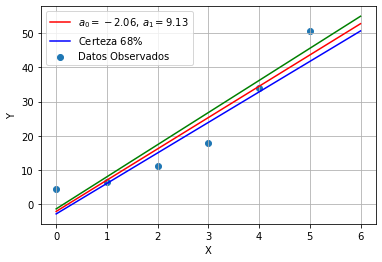

In [9]:
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

a0_estimated = mean_[0]
a1_estimated = mean_[1]

Xtest = np.linspace(0.,6.,100)

Yfit = Model1(Xtest, a0_estimated, a1_estimated)
YfitUp = Model1(Xtest,a0_estimated+0.74, a1_estimated+0.24)
YfitDown = Model1(Xtest, a0_estimated-0.73, a1_estimated-0.23)

plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$".format(a0_estimated, a1_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b', label=r'Certeza $68\%$')


plt.legend(loc=0)
plt.show()

b) Modelo 2: $a_{0}+a_{1}x+a_{2}x^{2}$ <br />

In [10]:
def Model2(x,a0,a1,a2):
    return a0+a1*x+a2*(x**2)

def Chi2(a0,a1,a2):
    Y_fit = Model2(X,a0,a1,a2)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_,a20_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_,a20_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        a2n_ = a20_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_,a2n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
            a20_ = a2n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_,a20_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_,a20_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps
mcmc = Metropolis(3.,0.1,2,0.3,50000)

a0= mcmc[:,0]
a1= mcmc[:,1]
a2 = mcmc[:,2]
mean_ = []

for i in range(3):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    print(mean, sigma2-mean, mean-sigma1)

100%|██████████| 50000/50000 [00:14<00:00, 3569.82it/s]


4.661846656228078 0.9840765687152855 0.854259547714213
-1.1281933396613173 0.8775825845627087 0.8687107460713814
2.056116812536631 0.16388599161244644 0.16068600504929198


$$
\hat{a}_{0} = 4.97_{-0.85}^{+0.93} \; \; \; \; \; \;  \; \; \; \; \; \;
\hat{a}_{1} = -1.44_{- 0.80}^{+0.81} \; \;  \; \; \; \;  \; \; \; \; \; \;
\hat{a}_{2} = 2.11_{-0.15}^{+0.16}
$$

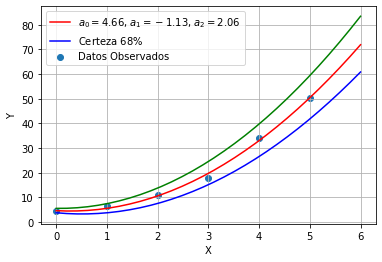

In [11]:
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
a0_estimated = mean_[0]
a1_estimated = mean_[1]
a2_estimated = mean_[2]

Xtest = np.linspace(0.,6.,30)
Yfit = Model2(Xtest, a0_estimated, a1_estimated,a2_estimated)

YfitUp = Model2(Xtest, a0_estimated+0.93, a1_estimated+0.81,a2_estimated+0.16)
YfitDown = Model2(Xtest, a0_estimated-0.85, a1_estimated-0.80,a2_estimated-0.15)

plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$, $a_2={:.2f}$".format(a0_estimated, a1_estimated,a2_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b', label=r'Certeza $68\%$')

plt.legend(loc=0)
plt.show()

c) Modelo 3: $a_{0}e^{a_{1}x}$

In [12]:
def Model3(x,a0,a1):
    return a0*np.exp(a1*x)

def Chi2(a0,a1):
    Y_fit = Model3(X,a0,a1)
    
    chi2 = 0.
    
    for i in range(len(X)):
        chi2 += (YObs[i]-Y_fit[i])**2/(2*Sigma[i]**2)
    
    return chi2

Chi2 = np.vectorize(Chi2)

def Metropolis(a00_,a10_, WidthSteps, NSteps):
    
    mcmc_steps = []
    
    burn_steps = 5000
    
    for i in tqdm(range(NSteps)):
        
        # Present
        P0 = np.exp(-Chi2(a00_,a10_))
        
        a0n_ = a00_ + WidthSteps*2.*(np.random.rand()-0.5)
        a1n_ = a10_ + WidthSteps*2.*(np.random.rand()-0.5)
        
        Pn = np.exp(- Chi2(a0n_,a1n_))
        
        alpha = Pn/P0
        
        beta = np.random.rand()
        
            
        if np.minimum(1, alpha > beta):
                
            a00_ = a0n_
            a10_ = a1n_
                
        if (i >= burn_steps):
            mcmc_steps.append([a00_,a10_]) 
        
        else:
            if (i >= burn_steps):
                mcmc_steps.append([a00_,a10_])  
    
    
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps
mcmc = Metropolis(2,1,0.3,50000)

a0= mcmc[:,0]
a1= mcmc[:,1]
mean_ = []

for i in range(2):
    mean=np.percentile(mcmc[:,i],50)
    sigma1 = np.percentile(mcmc[:,i], 16.)
    sigma2 = np.percentile(mcmc[:,i], 84.)
    mean_.append(mean)
    print(mean, sigma2-mean, mean-sigma1)

  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-12-2478d9edcd36>:32: RuntimeWarning: invalid value encountered in double_scalars
  alpha = Pn/P0
<ipython-input-12-2478d9edcd36>:32: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = Pn/P0
100%|██████████| 50000/50000 [00:28<00:00, 1756.23it/s]


4.43602031312722 0.38205074823964313 0.3570226195702091
0.49018048126032 0.017967164152641102 0.018081863088964145


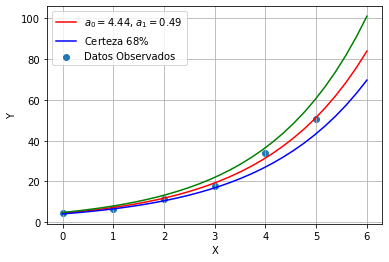

In [13]:
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
a0_estimated = mean_[0]
a1_estimated = mean_[1]

Xtest = np.linspace(0.,6.,30)
Yfit = Model3(Xtest, a0_estimated, a1_estimated)

YfitUp = Model3(Xtest, a0_estimated+0.365, a1_estimated+0.0177)
YfitDown = Model3(Xtest, a0_estimated-0.349, a1_estimated-0.0173)

plt.plot(Xtest, Yfit, c='r', label=r"$a_0= {:.2f}$, $a_1={:.2f}$".format(a0_estimated, a1_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='b', label=r'Certeza $68\%$')

plt.legend(loc=0)
plt.show()

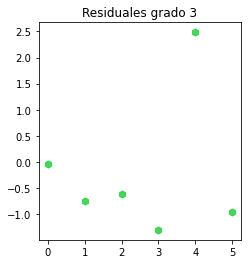

In [14]:
f=plt.figure(figsize=(8,4))
ax1 = f.add_subplot(121,title="Residuales grado 3" )
ax1.scatter(X,YObs-Model3(X, a0_estimated, a1_estimated),s=50,marker="h",color=(0.1,0.8,0.2,0.8))

## 6. Máxima Verosimilitud - Estimación de parámetros
**1.** Con los datos de https://github.com/asegura4488/MetodosCompu2021/blob/main/Week7/data/Likelihood.dat trazar las curvas de nivel del logaritmo de la verosimilitud asociados a los dos parámetros de la distribución $\mu$ y $\sigma$. 

In [33]:
file_ = 'data/Likelihood.dat'
data = np.loadtxt(file_, comments='#')

print(data)

[ 2.03133159  5.88677754  2.19574476  6.82188675  0.87939524  2.9515774
  4.4543329  -1.80439605 -5.84192597 -1.11349563]


<ipython-input-108-96a074df9bc7>:9: RuntimeWarning: divide by zero encountered in log
  distribution.append(np.log(Likelihood(i, mu_, sigma_)))


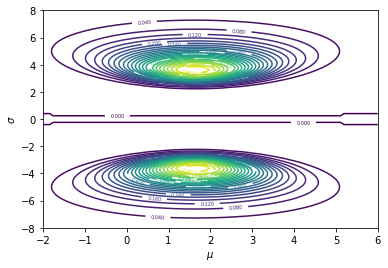

In [108]:
def Likelihood(x_, mu_, sigma_):
    if sigma_ != 0:
        return 1/np.sqrt(2*np.pi*(sigma_**2))*np.exp(-(x_-mu_)**2/(2*(sigma_**2)))

def log(mu_, sigma_):
    
    distribution = []
    for i in data:
        distribution.append(np.log(Likelihood(i, mu_, sigma_)))
        
    return sum(distribution)
    
log = np.vectorize(log)

sigma_ = np.linspace(-8,8,100)
mu_ = np.linspace(-2,6.,100)

mu, sigma = np.meshgrid(mu_,sigma_)

z = log( mu, sigma)

fig, ax = plt.subplots()
c = ax.contour(mu,sigma,np.exp(z-z.max()) ,25)

ax.clabel(c, inline=1, fontsize=5)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
plt.show()

-0.4040404040404031 -2.0


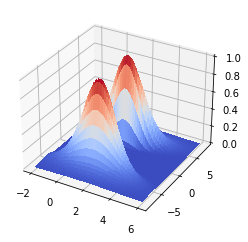

In [109]:
ii = np.where(np.exp(z-z.max()) == np.amin(np.exp(z-z.max())))

zmin_ = z[ii][0]

sigmamin, mumin = sigma_[ii[0]][0], mu_[ii[1]][0]

print(sigmamin, mumin)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(mu, sigma, np.exp(z-z.max()), cmap=cm.coolwarm ,linewidth=0, antialiased=False)